### Advanced Topics in Machine Learning
#### Assignment 2
- Joona Kareinen

#### Data loading

In [84]:
import json
import numpy as np

# Open the data file
file_path = './data/train-v2.0.json'
with open(file_path, 'rb') as f:
    # Load the data
    data_dict = json.load(f)


unique_contexts = []
contexts = []
pairs = []
for category in data_dict["data"]:
    for passage in category["paragraphs"]:
        context = passage["context"]
        unique_contexts.append(context)
        for qa in passage["qas"]:
            question = qa["question"]
            for answer in qa["answers"]:
                pairs.append([question, answer])
                contexts.append(context)


# Print some data
num_titles = len(unique_contexts)
print(f"In the dataset there are {num_titles} different categories with total of {len(pairs)} question/answer pairs.")
# Test that the data was loaded correctly

print(np.array(pairs[10:15]))


In the dataset there are 19035 different categories with total of 86821 question/answer pairs.
[['What was the first album Beyoncé released as a solo artist?'
  {'text': 'Dangerously in Love', 'answer_start': 505}]
 ['When did Beyoncé release Dangerously in Love?'
  {'text': '2003', 'answer_start': 526}]
 ['How many Grammy awards did Beyoncé win for her first solo album?'
  {'text': 'five', 'answer_start': 590}]
 ["What was Beyoncé's role in Destiny's Child?"
  {'text': 'lead singer', 'answer_start': 290}]
 ["What was the name of Beyoncé's first solo album?"
  {'text': 'Dangerously in Love', 'answer_start': 505}]]


#### Normalize the data, and create pairs and sentences arrayas for training and word2vec

In [86]:
import re
from pandas.core.common import flatten
import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s, is_answer):
    # Lowercase
    s = s.lower()
    s = unicodeToAscii(s)
    # Do some pruning to the data
    s = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', s)
    s = re.sub('\W', ' ', s).lower().split()

    return s

tokenized_sentences = []
for idx, pair in enumerate(pairs):
    s1 = normalizeString(pair[0], 0)
    s2 = normalizeString(pair[1]["text"], 1)
    if len(s1) > 1 and len(s2) > 1:
        tokenized_sentences.append(s1)
        tokenized_sentences.append(s2)

for sentence in tokenized_sentences[:10]:
    print(sentence)


['when', 'did', 'beyonce', 'start', 'becoming', 'popular']
['in', 'the', 'late', '1990s']
['what', 'areas', 'did', 'beyonce', 'compete', 'in', 'when', 'she', 'was', 'growing', 'up']
['singing', 'and', 'dancing']
['in', 'what', 'city', 'and', 'state', 'did', 'beyonce', 'grow', 'up']
['houston', 'texas']
['in', 'which', 'decade', 'did', 'beyonce', 'become', 'famous']
['late', '1990s']
['in', 'what', 'r', 'b', 'group', 'was', 'she', 'the', 'lead', 'singer']
['destiny', 's', 'child']


#### Count words and plot the sentence lengths

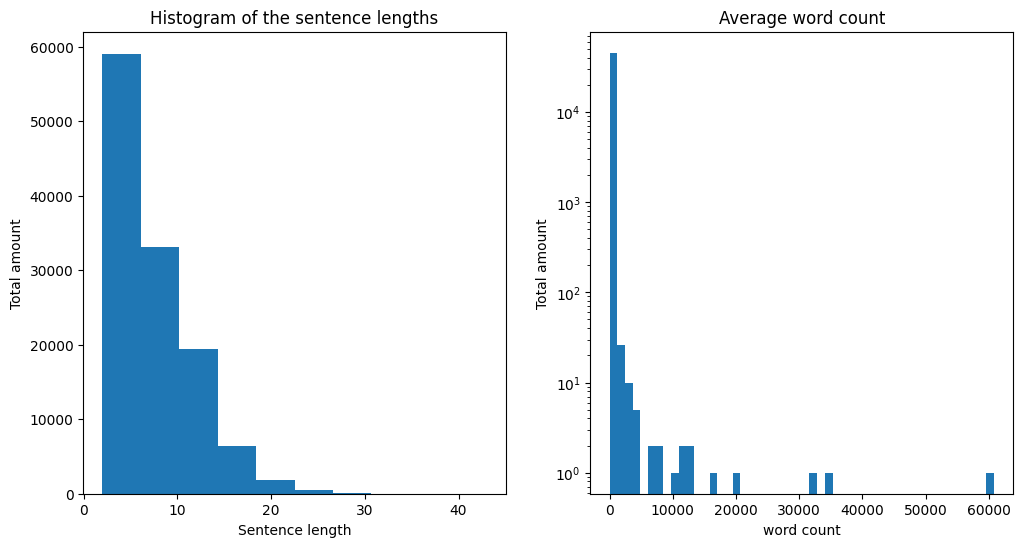

In [67]:
import matplotlib.pyplot as plt

word2count = {}
sen_len = []
for sentence in tokenized_sentences:
    sen_len.append(len(sentence))
    for word in sentence:
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

sorted_word2vec = {k: v for k, v in sorted(word2count.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(sen_len)
plt.title("Histogram of the sentence lengths")
plt.xlabel("Sentence length")
plt.ylabel("Total amount")

plt.subplot(1, 2, 2)
plt.hist(list(sorted_word2vec.values()), bins=50, log=True)
plt.title("Average word count")
plt.xlabel("word count")
plt.ylabel("Total amount")

plt.show()

#### Train word2vec

In [68]:
from gensim.models.word2vec import Word2Vec


model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

In [69]:
len(model.wv)


12647

In [70]:
print(f"Retrieved {len(unique_contexts)} passages")

Retrieved 19035 passages


In [71]:
unique_contexts[1]

'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, Beyoncé (2013), was distinguished from previous releases by its experimental production and exploratio

# 2. Train and evaluate models:

In [72]:
from sentence_transformers import SentenceTransformer, CrossEncoder

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

c:\Users\Joona\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
import os
import pickle

# Define hnswlib index path
embeddings_cache_path = './qa_embeddings_cache.pkl'

# Load cache if available
if os.path.exists(embeddings_cache_path):
    print('Loading embeddings cache')
    with open(embeddings_cache_path, 'rb') as f:
        corpus_embeddings = pickle.load(f)
# Else compute embeddings
else:
    print('Computing embeddings')
    corpus_embeddings = semb_model.encode(unique_contexts, convert_to_tensor=True, show_progress_bar=True)
    # Save the index to a file for future loading
    print(f'Saving index to: \'{embeddings_cache_path}\'')
    with open(embeddings_cache_path, 'wb') as f:
        pickle.dump(corpus_embeddings, f)

Loading embeddings cache


In [74]:
import os
import hnswlib
import time
start = time.time()
# Create empthy index
index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = './qa_hnswlib_100.index'

# Load index if available
if os.path.exists(index_path):
    print('Loading index...')
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print('Start creating HNSWLIB index')
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=100, M=64) # see https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md for parameter description
    # Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print(f'Saving index to: {index_path}')
    index.save_index(index_path)

end = time.time()
print(f"Exectution time: {int((end - start) / 60)}:{int((end - start) % 60)} min:sec")

Loading index...
Exectution time: 0:0 min:sec


In [108]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto", torch_dtype=torch.float16)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [109]:
input_text = 'Translate the following sentence from Italian to English: "Amo la pizza"'

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = model.generate(input_ids, max_new_tokens=32)
output_text = tokenizer.decode(output_ids[0])
print(output_text)

<pad> "I love pizza"</s>


In [120]:
def qa_pipeline(
    question, print_flag,
    similarity_model=semb_model,
    embeddings_index=index,
    re_ranking_model=xenc_model,
    generative_model=model,
    device=device
):
    if not question.endswith('?'):
        question = question + '?'
    # Embed question
    question_embedding = similarity_model.encode(question, convert_to_tensor=True)
    # Search documents similar to question in index
    corpus_ids, distances = embeddings_index.knn_query(question_embedding.cpu(), k=64)
    # Re-rank results
    xenc_model_inputs = [(question, unique_contexts[idx]) for idx in corpus_ids[0]]
    cross_scores = re_ranking_model.predict(xenc_model_inputs)
    # Get best matching passage
    passage_idx = np.argsort(-cross_scores)[0]
    passage = unique_contexts[corpus_ids[0][passage_idx]]
    # Encode input
    input_text = f"Given the following passage, answer the related question.\n\nPassage:\n\n{passage}\n\nQ: {question}"
    if print_flag:
        print('INPUT TEXT:', input_text, "\n")
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
    # Generate output
    output_ids = generative_model.generate(input_ids, max_new_tokens=512)
    # Decode output
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Return result
    return output_text

In [121]:
question = input("Ask a question >>> ")  # e.g., "How many fingers in a hand?", "What is the oldest newspaper in Chile?", ...
print()

print(qa_pipeline(question, True))


INPUT TEXT: Given the following passage, answer the related question.

Passage:

Although dance-oriented, electronic pop and ballad-oriented rock dominated the 1980s, soft rock songs still enjoyed a mild success thanks to artists like Sheena Easton, Amy Grant, Lionel Richie, Christopher Cross, Dan Hill, Leo Sayer, Billy Ocean, Julio Iglesias, Bertie Higgins and Tommy Page. No song spent more than six weeks at #1 on this chart during the 1980s, with nine songs accomplishing that feat. Two of these were by Lionel Richie, "You Are" in 1983 and "Hello" in 1984, which also reached #1 on the Hot 100.

Q: hello? 

Lionel Richie


# 3. Add voice interactivity:

Install required python packages

In [112]:
!pip install numpy scipy librosa unidecode inflect openai-whisper

#### Load the tacotron and waveglow models from Torchhub

- Tacotron2 model produces mel spectrograms from text
- Waveglow model takes mel spectrogram and generates speech

Write some text and transform it to numeric sequence

### Define text2speech function using all the previous knowledge

In [88]:
import torch
from scipy.io.wavfile import write
import whisper

# Load tacotron
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

# Load waveglow
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

# Load utils
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in C:\Users\Joona/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\Joona/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
c:\Users\Joona\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Using cache found in C:\Users\Joona/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [116]:
def text2speech(input):
    rate = 22050
    # Transform the text to numeric sequence
    sequences, lengths = utils.prepare_input_sequence([input])

    # Use tacotron2 model to create a mel spectrogram from the numeric sequence
    
    with torch.no_grad():
        mel, _, _ = tacotron2.infer(sequences, lengths)
    
    # Use the waveglow model to produce audio signal from the mel spectrogram
    with torch.no_grad():
        audio = waveglow.infer(mel)
    
    # return the audio signal
    audio_numpy = audio[0].data.cpu().numpy()
    
    return audio_numpy, rate

In [94]:
text = "When did Beyoncé release Dangerously in Love?"

audio_numpy, rate = text2speech(text)

write("audio.wav", rate, audio_numpy)
Audio(audio_numpy, rate=rate) 

### Define speech2text function
Did not do sound recording as I did not have microphone on my pc

In [62]:
model = whisper.load_model("base")

result = model.transcribe("./audio.wav")
print(result["text"])

 when did Beyonce release dangerously in love?


## Make something app like

In [131]:
import random

pair = random.choice(pairs)
question = pair[0]
answer = pair[1]["text"]
print(f"Q: {question}")
print(f"A: {answer}")

output = qa_pipeline(question, 0)
print(f"Predicted: {output}")


Q: Who was the second Phagmodru ruler?
A: Jamyang Shakya Gyaltsen
Predicted: Jamyang Shakya Gyaltsen


In [134]:

audio_numpy, rate = text2speech(question)

Audio(audio_numpy, rate=rate, autoplay=True)

In [133]:
audio_numpy, rate = text2speech(output)

Audio(audio_numpy, rate=rate, autoplay=True)